## _Reinforcment Learning_
### Multi Armed Bandits


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

class K_Arm_Bandit:
    def __init__(self, var, K):
        self.var = var
        self.K = K
        self.arm_means = [np.random.normal(loc = 0, scale = np.sqrt(3), size = 1) for arms in range(self.K)]
        self.arm_reward_distributions = [np.random.normal(loc=self.arm_means[arm], scale=np.sqrt(1), size=1000) for arm in range(self.K)] 
        self.arms = [arms for arms in range(self.K)]
        self.arm_selection_count = [0 for arms in range(self.K)]
        self.arm_reward_estimate = [0 for arms in range(self.K)]
        np.random.seed(40)

    def _pull_arm(self, selected_arm):
        """Get reward for pulling a specific arm"""
        reward = np.random.normal(loc = self.arm_means[selected_arm], scale = np.sqrt(self.var), size = 1)
        return reward

    def show_arm_reward_distributions(self):
        """
        Show reward distributions for each arm
        """
        plt.figure(figsize=(15, 10))
        plt.violinplot(self.arm_reward_distributions, showextrema=True, showmeans=True)
        plt.title("{}-Arm Bandit Reward Distributions".format(self.K), fontsize=25)
        plt.xlabel("Arm", fontsize=20)
        plt.ylabel("Reward Distribution", fontsize=20)
        plt.show()
    
    def e_greedy(self, epsilon=0.1, alpha=0, steps=100, opt_init=0):
        """
        epsilon:   The percentage exploration is chosen over exploitation
        
        alpha:     Learning rule parameter:
                   If alpha is 0, then alpha is chosen as 1 over the number of times a particular action is chosen.
                   Which is the average times a specific arm was selected
               
        steps:     The number of steps used for the algorithim to train
        opt_init:  Defines the initial reward estimate.
        
        Note: When epsilon is 0, e-greedy becomes greedy.
        """
        if opt_init != 0:
            self.arm_reward_estimate = [opt_init for arms in range(self.K)]
            
        rewards = []
        count = 0 
        reward = 0
        accumulated_reward = 0
        
        for i in range(steps):
            # Choose an arm
            if np.random.random() < epsilon: 
                # Explore
                selected_arm = np.random.choice(self.arms)
            else:
                # Exploit    
                max_reward = np.max(self.arm_reward_estimate)
                choices = [idx for idx, val in enumerate(self.arm_reward_estimate) if val == max_reward]
                if len(choices) == 1:
                    selected_arm = choices[0]
                else:
                    selected_arm = np.random.choice(choices)
                    
            # get reward from chosen arm
            reward = self._pull_arm(selected_arm)

            # Update chosen arm count
            self.arm_selection_count[selected_arm] += 1

            # Update alpha (-> 1/n)
            if alpha == 0:
                alpha = 1/self.arm_selection_count[selected_arm]

            # Update chosen arm's reward estimate
            oldRewardEstimate = self.arm_reward_estimate[selected_arm]
            self.arm_reward_estimate[selected_arm] = oldRewardEstimate + alpha * (reward - oldRewardEstimate)

            # Store Average reward per time step
            count += 1
            accumulated_reward += reward 
            rewards.append(accumulated_reward/count)
        
        # reset global lists
        self.arm_selection_count = [0 for arms in range(self.K)]
        self.arm_reward_estimate = [0 for arms in range(self.K)]

        return rewards
        
    def UCB(self, steps=100, opt_init=0, c = 2, alpha=0):
        if opt_init != 0:
            self.arm_reward_estimate = [opt_init for arms in range(self.K)]
            
        rewards = [] 
        reward = 0
        accumulated_reward = 0
        t = 0
        upper_bound_estimates = [0 for arms in range(self.K)]
        
        for i in range(steps):
            # increment time step
            t += 1
            
            # Compute upper bound estimates
            for idx, est in enumerate(self.arm_reward_estimate):
                if self.arm_selection_count[idx] == 0:
                    upper_bound_estimates[idx] = est
                else:
                    upper_bound_estimates[idx] = est + c * np.sqrt(np.log(t)/self.arm_selection_count[idx])
            
            # Choose an arm
            selected_arm = np.argmax(upper_bound_estimates)
        
            # get reward from chosen arm
            reward = self._pull_arm(selected_arm)

            # Update chosen arm count
            self.arm_selection_count[selected_arm] += 1

            # Update alpha (-> 1/n)
            if alpha == 0:
                alpha = 1/self.arm_selection_count[selected_arm]

            # Update chosen arm's reward estimate
            oldRewardEstimate = self.arm_reward_estimate[selected_arm]
            self.arm_reward_estimate[selected_arm] = oldRewardEstimate + alpha * (reward - oldRewardEstimate)

            # Store Average reward per time step
            accumulated_reward += reward 
            #rewards[i] = accumulated_reward/t
            rewards.append(accumulated_reward/t)

        self.arm_selection_count = [0 for arms in range(self.K)]
        self.arm_reward_estimate = [0 for arms in range(self.K)]

        return rewards

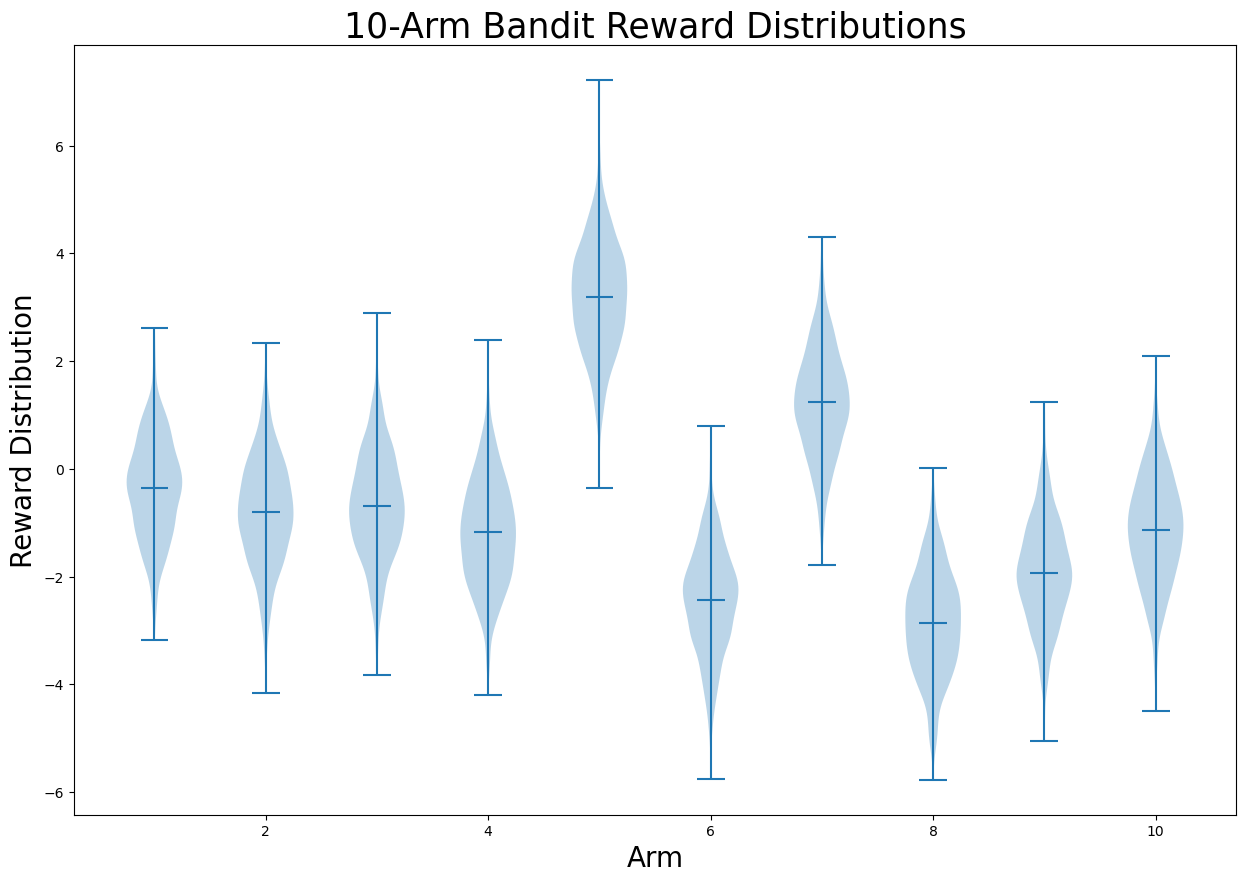

In [2]:
MAB = K_Arm_Bandit(var=1, K=10)
MAB.show_arm_reward_distributions()

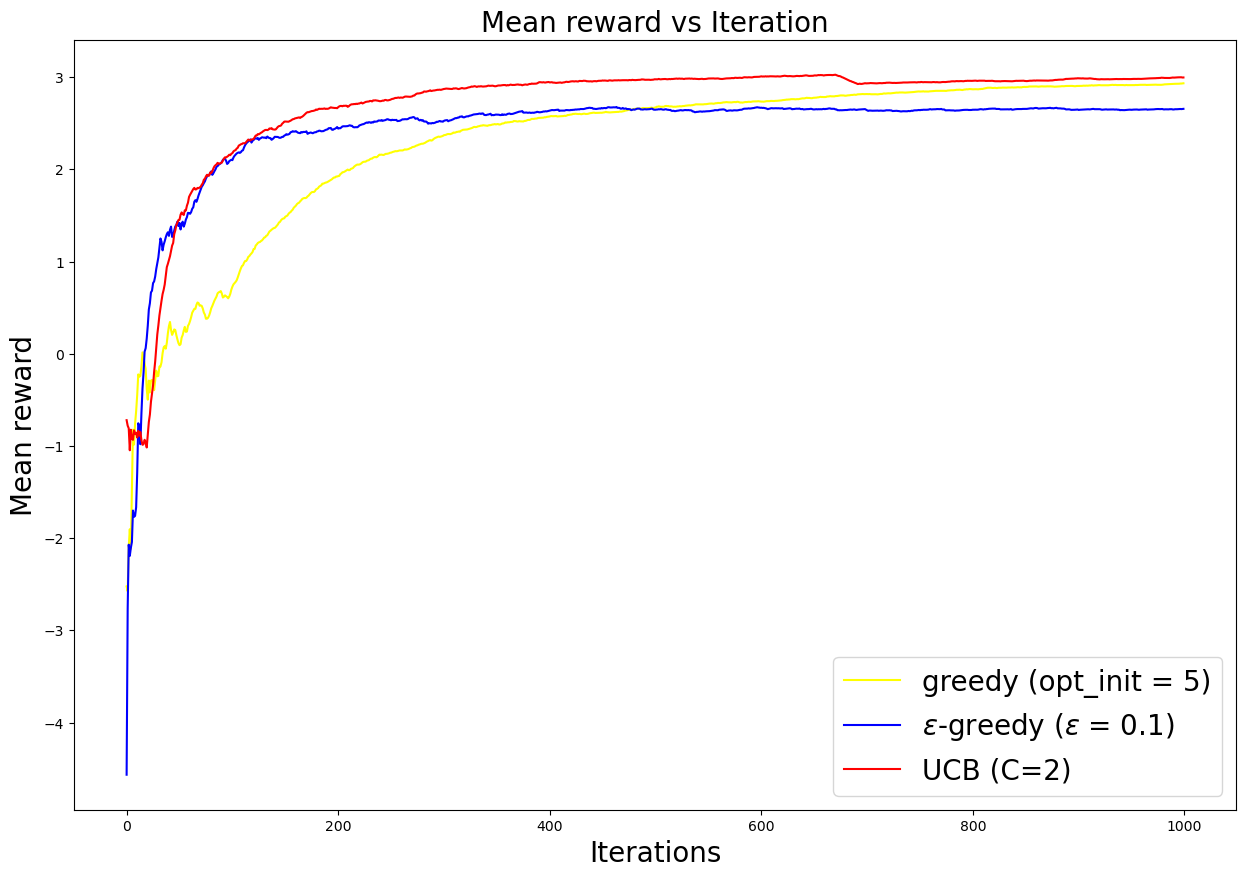

In [3]:
plt.figure(figsize=(15, 10))
plt.plot(MAB.e_greedy(epsilon=0, alpha = 0.1, opt_init=5, steps=1000), color='yellow', label='greedy (opt_init = 5)')
plt.plot(MAB.e_greedy(epsilon=0.1, alpha = 0, steps=1000), color='blue', label=r'$\epsilon$-greedy ($\epsilon$ = 0.1)')
plt.plot(MAB.UCB(c = 2, opt_init=0, steps=1000), color='red', label='UCB (C=2)')

plt.title("Mean reward vs Iteration", fontsize=20)
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Mean reward", fontsize=20)
plt.legend(fontsize=20)
plt.show()


100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


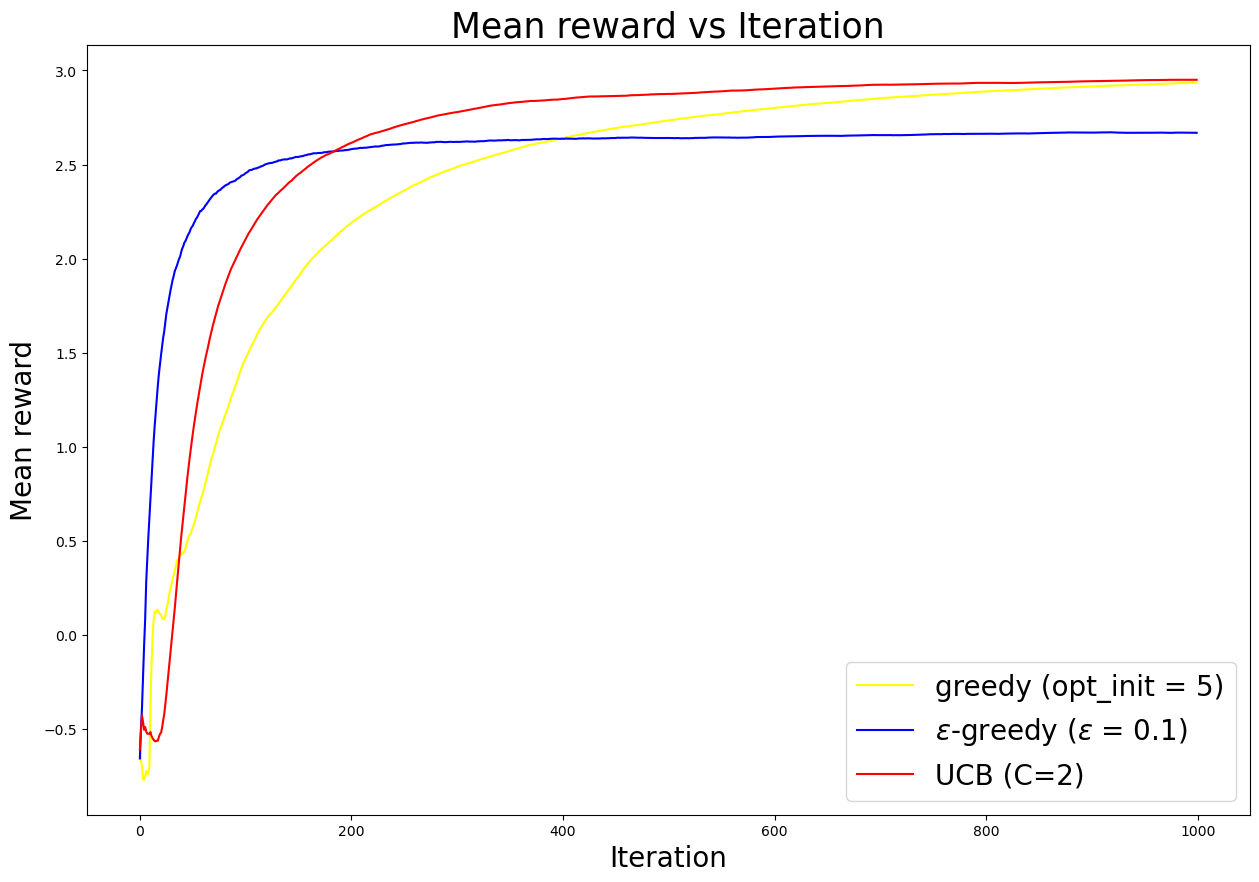

In [4]:
avg_greedy = np.zeros((101, 1000))
avg_e_greedy = np.zeros((101, 1000))
avg_ucb = np.zeros((101, 1000))

for i in tqdm(range(100)):
    avg_greedy[i,:] =  np.array(MAB.e_greedy(epsilon=0, alpha = 0.1, opt_init=5, steps=1000))[:,0]
    avg_e_greedy[i,:] =  np.array(MAB.e_greedy(epsilon=0.1, alpha = 0, opt_init=0, steps=1000))[:,0]
    avg_ucb[i,:] =  np.array(MAB.UCB(c = 2, opt_init=0, steps=1000))[:,0]

avg_greedy[-1,:] = np.average(avg_greedy[:100,:], axis=0)
avg_e_greedy[-1,:] = np.average(avg_e_greedy[:100,:], axis=0)
avg_ucb[-1,:] = np.average(avg_ucb[:100,:], axis=0)

plt.figure(figsize=(15, 10))
plt.plot(avg_greedy[100,:], color='yellow', label='greedy (opt_init = 5)')
plt.plot(avg_e_greedy[100,:], color='blue', label=r'$\epsilon$-greedy ($\epsilon$ = 0.1)')
plt.plot(avg_ucb[100,:], color='red', label='UCB (C=2)')

plt.title("Mean reward vs Iteration", fontsize=25)
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("Mean reward", fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [13]:
# Hyperparameters for tuning
alphas = np.geomspace(1/4096, 4, num=20)
epsilons = np.geomspace(1/4096, 4, num=20)
cs = np.geomspace(1/4096, 4, num=20)

# greedy 
greedy_averages = []

for a in tqdm(alphas, "Computing Greedy..."):
    avg_reward_per_step_greedy = MAB.e_greedy(epsilon=0, alpha = a, opt_init=5, steps=1000)
    avg_reward_over_all_steps_greedy = sum(avg_reward_per_step_greedy)/len(avg_reward_per_step_greedy)
    greedy_averages.append(avg_reward_over_all_steps_greedy)

# e-greedy 
e_greedy_averages = []

for e in tqdm(epsilons, r'Computing E-greedy...'):
    avg_reward_per_step_e_greedy = MAB.e_greedy(epsilon=e, opt_init=0, steps=1000)
    avg_reward_over_all_steps_e_greedy = sum(avg_reward_per_step_e_greedy)/len(avg_reward_per_step_e_greedy)
    e_greedy_averages.append(avg_reward_over_all_steps_e_greedy)
    
# ucb
ucb_averages = []

for c_ in tqdm(cs, "Computing UCB..."):
    avg_reward_per_step_ucb = MAB.UCB(c = c_, opt_init=0, steps=1000)
    avg_reward_over_all_steps_ucb = sum(avg_reward_per_step_ucb)/len(avg_reward_per_step_ucb)
    ucb_averages.append(avg_reward_over_all_steps_ucb)
    


Computing UCB...: 100%|██████████| 20/20 [00:01<00:00, 18.07it/s]


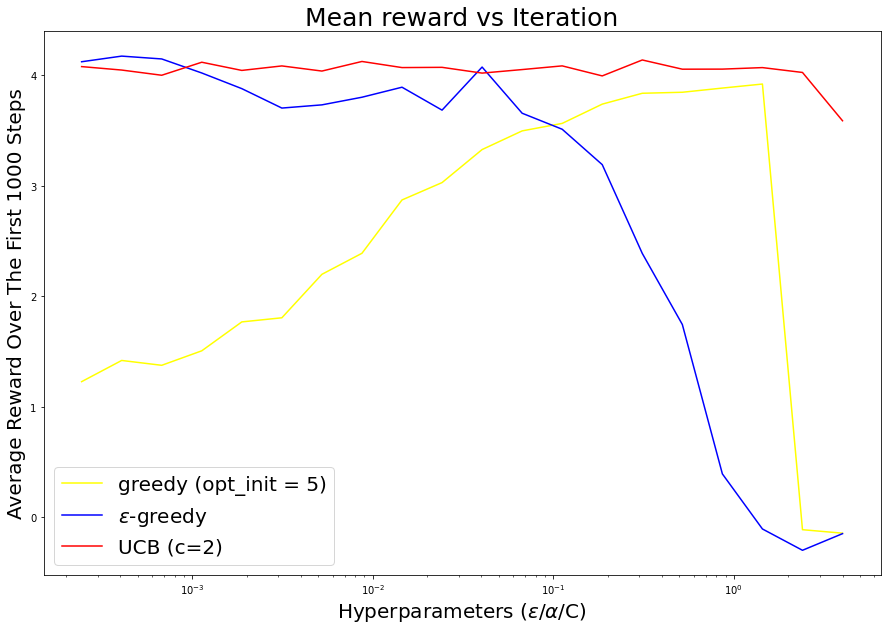

In [14]:
# Comparison plot
plt.figure(figsize=(15, 10))
plt.plot(alphas, greedy_averages, color='yellow', label='greedy (opt_init = 5)')
plt.plot(epsilons, e_greedy_averages, color='blue', label='$\epsilon$-greedy')
plt.plot(cs, ucb_averages, color='red', label='UCB (c=2)')

plt.title("Mean reward vs Iteration", fontsize=25)
plt.xlabel(r'Hyperparameters ($\epsilon/\alpha$/C)', fontsize=20)
plt.ylabel("Average Reward Over The First 1000 Steps", fontsize=20)
plt.legend(fontsize=20)
plt.xscale("log")
plt.show()